In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, chi2
from sklearn.svm import SVC
from sklearn import metrics
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import roc_curve, auc,f1_score,RocCurveDisplay, precision_score, recall_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import make_column_selector as selector
from sklearn.ensemble import RandomForestClassifier

In [2]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [3]:
df = pd.read_csv("Churn_modelling.csv")
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.0000,1,1,1,101348.8800,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.8600,1,0,1,112542.5800,0
2,3,15619304,Onio,502,France,Female,42,8,159660.8000,3,1,0,113931.5700,1
3,4,15701354,Boni,699,France,Female,39,1,0.0000,2,0,0,93826.6300,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.8200,1,1,1,79084.1000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.0000,2,1,0,96270.6400,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.6100,1,1,1,101699.7700,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.0000,1,0,1,42085.5800,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.3100,2,1,0,92888.5200,1


In [4]:
df_dropped = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis = 1)          # Dropped the unecessary part of the dataset that will not contribute to machine learning prediction
df_dropped

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.0000,1,1,1,101348.8800,1
1,608,Spain,Female,41,1,83807.8600,1,0,1,112542.5800,0
2,502,France,Female,42,8,159660.8000,3,1,0,113931.5700,1
3,699,France,Female,39,1,0.0000,2,0,0,93826.6300,0
4,850,Spain,Female,43,2,125510.8200,1,1,1,79084.1000,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.0000,2,1,0,96270.6400,0
9996,516,France,Male,35,10,57369.6100,1,1,1,101699.7700,0
9997,709,France,Female,36,7,0.0000,1,0,1,42085.5800,1
9998,772,Germany,Male,42,3,75075.3100,2,1,0,92888.5200,1


After dropping the unecessary part of the dataset, we will get this sum of dataset. The remaining part of the dataset contains both continous and categorical data. Creditscore, Age, Tenure, Balance, NumOfProducts, and EstimatedSalary are continous, while Geography, Gender, HasCrCard, IsActiveMember are categorical.

In [5]:
df_dropped.isnull().values.any()        #Check whether there are any values that are null

False

In [6]:
stayed = df_dropped['Exited'].value_counts()[0]         # calculating the number of people that churned in this dataset
exited = df_dropped['Exited'].value_counts()[1]
print('Number of people exited: {}'.format(exited))
print('Number of people stayed: {}'.format(stayed))
print('Churn rate: {:.2%}'.format((exited/stayed)))     # Calculating the churn rate

Number of people exited: 2037
Number of people stayed: 7963
Churn rate: 25.58%


<AxesSubplot:title={'center':'Tenure Year(s) Distribution'}>

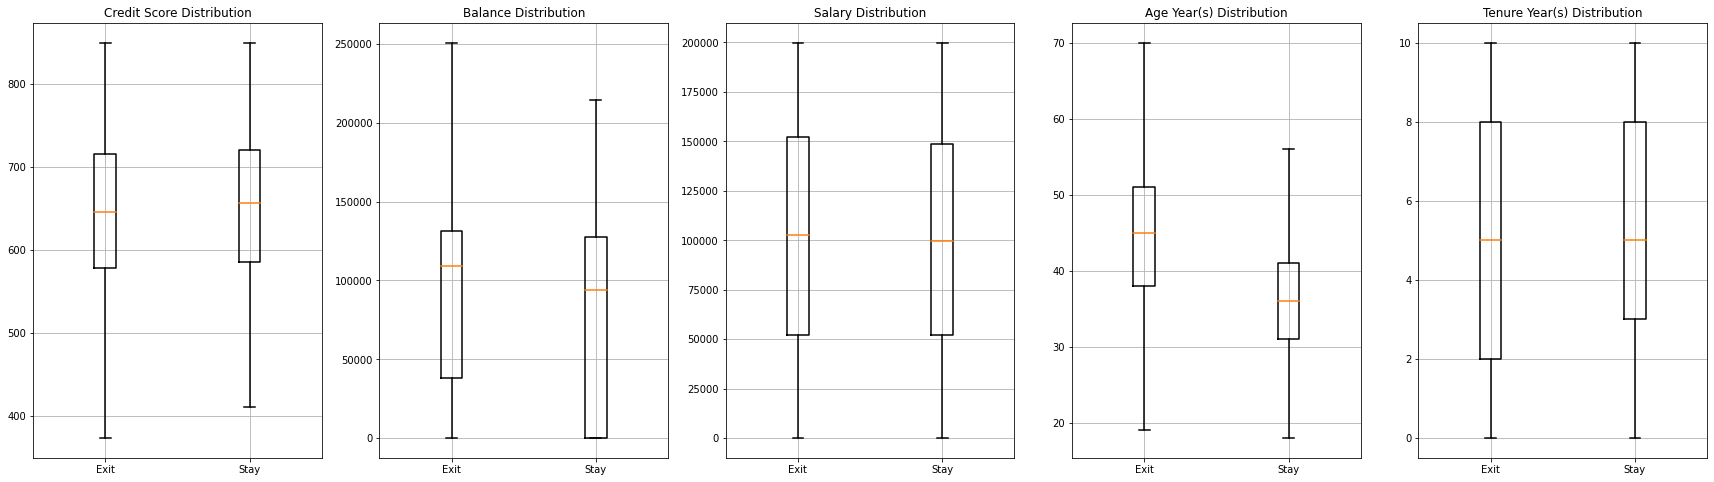

In [19]:
exit_credit = []                        # plotting figures for our continous data
stay_credit = []
exit_balance = []
stay_balance = []
exit_salary = []
stay_salary = []
exit_age = []
stay_age = []
exit_tenure = []
stay_tenure = []

for index, data in df_dropped.iterrows():
    if(data['Exited']):
        exit_credit.append(data['CreditScore'])
        exit_balance.append(data['Balance'])
        exit_salary.append(data['EstimatedSalary'])
        exit_age.append(data['Age'])
        exit_tenure.append(data['Tenure'])
    else:
        stay_credit.append(data['CreditScore'])
        stay_balance.append(data['Balance'])
        stay_salary.append(data['EstimatedSalary'])
        stay_age.append(data['Age'])
        stay_tenure.append(data['Tenure'])

credit_df = pd.Series(exit_credit, name="Exit").to_frame().join(pd.Series(stay_credit, name="Stay"))
balance_df = pd.Series(exit_balance, name="Exit").to_frame().join(pd.Series(stay_balance, name="Stay"))
salary_df = pd.Series(exit_salary, name="Exit").to_frame().join(pd.Series(stay_salary, name="Stay"))
age_df = pd.Series(exit_age, name="Exit").to_frame().join(pd.Series(stay_age, name="Stay"))
tenure_df = pd.Series(exit_tenure, name="Exit").to_frame().join(pd.Series(stay_tenure, name="Stay"))

f, axes = plt.subplots(1, 5, figsize=(30,8))
credit_df.plot(kind="box", boxprops=dict(linestyle='-', linewidth=1.5), flierprops=dict(linestyle='-', linewidth=1.5), medianprops=dict(linestyle='-', linewidth=1.5),
               whiskerprops=dict(linestyle='-', linewidth=1.5), capprops=dict(linestyle='-', linewidth=1.5), showfliers=False, grid=True, rot=0, title='Credit Score Distribution', ax=axes[0])
balance_df.plot(kind="box", boxprops=dict(linestyle='-', linewidth=1.5), flierprops=dict(linestyle='-', linewidth=1.5), medianprops=dict(linestyle='-', linewidth=1.5),
               whiskerprops=dict(linestyle='-', linewidth=1.5), capprops=dict(linestyle='-', linewidth=1.5), showfliers=False, grid=True, rot=0, title='Balance Distribution', ax=axes[1])
salary_df.plot(kind="box", boxprops=dict(linestyle='-', linewidth=1.5), flierprops=dict(linestyle='-', linewidth=1.5), medianprops=dict(linestyle='-', linewidth=1.5),
               whiskerprops=dict(linestyle='-', linewidth=1.5), capprops=dict(linestyle='-', linewidth=1.5), showfliers=False, grid=True, rot=0, title='Salary Distribution', ax=axes[2])
age_df.plot(kind="box", boxprops=dict(linestyle='-', linewidth=1.5), flierprops=dict(linestyle='-', linewidth=1.5), medianprops=dict(linestyle='-', linewidth=1.5),
               whiskerprops=dict(linestyle='-', linewidth=1.5), capprops=dict(linestyle='-', linewidth=1.5), showfliers=False, grid=True, rot=0, title='Age Year(s) Distribution', ax=axes[3])
tenure_df.plot(kind="box", boxprops=dict(linestyle='-', linewidth=1.5), flierprops=dict(linestyle='-', linewidth=1.5), medianprops=dict(linestyle='-', linewidth=1.5),
               whiskerprops=dict(linestyle='-', linewidth=1.5), capprops=dict(linestyle='-', linewidth=1.5), showfliers=False, grid=True, rot=0, title='Tenure Year(s) Distribution', ax=axes[4])

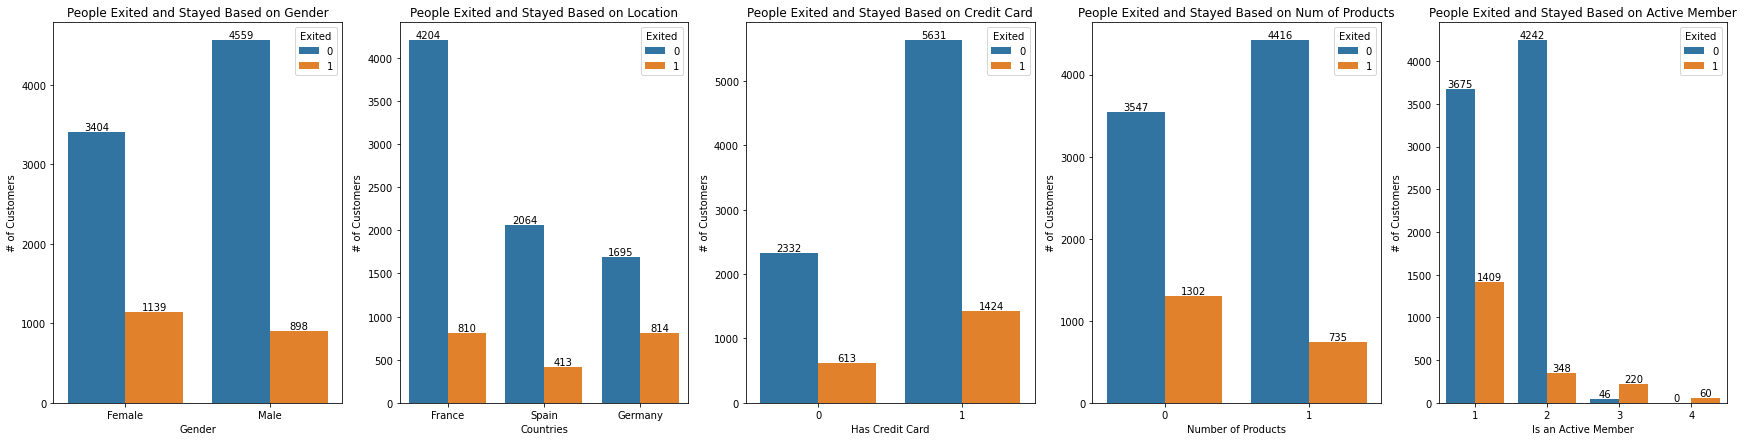

In [20]:
f, axes = plt.subplots(1,5, figsize=(30,7))                                         # plotting figures for our categorical data
ax1 = sns.countplot(data=df_dropped, x="Gender",hue="Exited", ax=axes[0])
ax1.set_title('People Exited and Stayed Based on Gender')
ax1.set_xlabel('Gender')
ax1.set_ylabel('# of Customers')
for label in ax1.containers:
    ax1.bar_label(label)
ax2 = sns.countplot(data=df_dropped, x="Geography",hue="Exited", ax=axes[1])
ax2.set_title('People Exited and Stayed Based on Location')
ax2.set_xlabel('Countries')
ax2.set_ylabel('# of Customers')
for label in ax2.containers:
    ax2.bar_label(label)
ax3 = sns.countplot(data=df_dropped, x="HasCrCard",hue="Exited", ax=axes[2])
ax3.set_title('People Exited and Stayed Based on Credit Card')
ax3.set_xlabel('Has Credit Card')
ax3.set_ylabel('# of Customers')
for label in ax3.containers:
    ax3.bar_label(label)
ax4 = sns.countplot(data=df_dropped, x="IsActiveMember",hue="Exited", ax=axes[3])
ax4.set_title('People Exited and Stayed Based on Num of Products')
ax4.set_xlabel('Number of Products')
ax4.set_ylabel('# of Customers')
for label in ax4.containers:
    ax4.bar_label(label)
ax5 = sns.countplot(data=df_dropped, x="NumOfProducts",hue="Exited", ax=axes[4])
ax5.set_title('People Exited and Stayed Based on Active Member')
ax5.set_xlabel('Is an Active Member')
ax5.set_ylabel('# of Customers')
for label in ax5.containers:
    ax5.bar_label(label)

# Feature Selection
Since there are a lot of different features in the dataset, there are chances that some of the features have small to none impact on the machine learning, and so ANOVA and chi squared and random forest based feature selection are employed to find those features and possibly dropped them.

In [7]:
df_copy = df_dropped.copy()
df_copy.dtypes

CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [8]:
gender_labels = {'Female':0, 'Male':1}                                                  # Map the categorical data to integer
geography_labels = {'France':0, 'Germany':1, 'Spain':2}
df_copy["Gender"] = df_copy["Gender"].map(gender_labels).astype('object')
df_copy["Geography"] = df_copy["Geography"].map(geography_labels).astype('object')
df_copy['HasCrCard'] = df_copy['HasCrCard'].astype('object')
df_copy['IsActiveMember'] = df_copy['IsActiveMember'].astype('object')
label = df_copy.columns[0:10]

In [9]:
column_trans = ColumnTransformer(transformers=                                         # Random forest based feature selection
        [('num', MinMaxScaler(), selector(dtype_exclude="object")),
        ('cat', OrdinalEncoder(), selector(dtype_include="object"))],
        remainder='drop')
clf = RandomForestClassifier(random_state=42, n_jobs=10, class_weight='balanced')

pipeline = Pipeline([('prep',column_trans), ('clf', clf)])

In [11]:
clf.fit(df_copy[label], df['Exited'])

RandomForestClassifier(class_weight='balanced', n_jobs=10, random_state=42)

In [12]:
anova_fs = SelectKBest(score_func=f_classif, k='all')                               # Anova test based feature selection
anova_fs.fit(df_copy[label], df['Exited'])
chi2_fs = SelectKBest(score_func=chi2, k='all')                                     # Chi squared based feature selection
chi2_fs.fit(df_copy[label], df['Exited'])

fs_df = pd.DataFrame(data = zip(anova_fs.scores_, chi2_fs.scores_, pipeline['clf'].feature_importances_), index = list(label),columns = ['Anova Score', 'Chi2 Score', 'Random Forest'])
fs_df

,Anova Score,Chi2 Score,Random Forest
CreditScore,7.3445,105.4035,0.1342
Geography,12.9331,11.8533,0.0384
Gender,114.7280,51.5399,0.0209
Age,886.0633,2300.4175,0.2563
Tenure,1.9602,3.2705,0.0792
Balance,142.4738,7151302.7759,0.1414
NumOfProducts,22.9152,5.0554,0.1334
HasCrCard,0.5094,0.1500,0.0184
IsActiveMember,249.8008,118.1994,0.0363
EstimatedSalary,1.4633,48350.8818,0.1417


Anova test, Chi Squared test, and random forest based feature selection are utilized. All of these test are used to test for different condition, since the dataset has both numerical and categorical data. In the end, Tenure and HasCreditCard data are dropped since they scored the lowest on the tests leaving us with CreditScore, Geography, Gender, Age, Balance, NumOfProducts, IsActiveMember, EstimatedSalary to be considered.

In [13]:
df_copy["Gender"] = df_copy["Gender"].astype('int64')
df_copy["Geography"] = df_copy["Geography"].astype('int64')
df_copy['IsActiveMember'] = df_copy['IsActiveMember'].astype('int64')

In [14]:
X = df_copy.iloc[:, [0, 1, 2, 3, 5, 6, 8, 9]]               # dropping Tenure and HasCrCard data for training and testing data
y = df_copy['Exited']

# Pre-Processing

In [15]:
num_ft = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

In [16]:
sc = StandardScaler()                                   # Scaling only the continous data part of the training dataset

X_train_scaled[num_ft] = sc.fit_transform(X_train[num_ft])
X_test_scaled[num_ft] = sc.fit_transform(X_test[num_ft])

# Machine Learning

In [17]:
svc = SVC()  # The best hyperparameter for all svm

In [36]:
param_grid = {'C': [0.1, 0.5, 1, 2, 3, 4, 5, 10], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['linear', 'rbf', 'sigmoid']} 
grid = GridSearchCV(svc, param_grid, refit=True, verbose=1)
grid.fit(X_train_scaled, y_train)
grid.best_params_

Fitting 5 folds for each of 120 candidates, totalling 600 fits


{'C': 4, 'gamma': 0.1, 'kernel': 'rbf'}

In [18]:
sv1 = SVC(C=4, gamma=0.1, kernel='rbf')
sv1.fit(X_train_scaled, y_train)
y_pred_sv1 = sv1.predict(X_test_scaled)

print("\nPerformance score using all features:")
print('F1:', f1_score(y_test, y_pred_sv1))
print('Accuracy:', accuracy_score(y_test, y_pred_sv1))
print('Precision:', precision_score(y_test, y_pred_sv1))
print('Recall:', recall_score(y_test, y_pred_sv1))
print('MEA:', mean_absolute_error(y_test, y_pred_sv1))
print('ROC-AUC:', roc_auc_score(y_test, y_pred_sv1))

svm_non = np.array([accuracy_score(y_test, y_pred_sv1), precision_score(y_test, y_pred_sv1), recall_score(y_test, y_pred_sv1), f1_score(y_test, y_pred_sv1), mean_absolute_error(y_test, y_pred_sv1), roc_auc_score(y_test, y_pred_sv1)])



Performance score using all features:
F1: 0.5532381997804611
Accuracy: 0.8643333333333333
Precision: 0.84
Recall: 0.41243862520458263
MEA: 0.13566666666666666
ROC-AUC: 0.696173268232262


In [19]:
score = cross_val_score(sv1, X_test_scaled, y_test, cv=5)
print('Performance for Support Vector Machine Cross-Validation')
print('Mean accuracy: ',score.mean())
print('Variance: ',score.var())
print('Standard Deviation: ',score.std())

Performance for Support Vector Machine Cross-Validation
Mean accuracy:  0.866
Variance:  5.955555555555539e-05
Standard Deviation:  0.00771722460186014


In [20]:
params = {'learning_rate': [0.05,0.10,0.15,0.20,0.25,0.30],
          'max_depth': [ 3, 4, 5, 6, 8, 10, 12, 15],
          'min_child_weight': [ 1, 3, 5, 7 ],
          'gamma': [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
          'colsample_bytree': [ 0.3, 0.4, 0.5 , 0.7 ],
          'booster': ['gbtree', 'gblinear', 'dart'],
          'base_score': [0.10,0.20,0.30,0.40,0.50,0.60]}

xg = xgb.XGBClassifier()

randSearch = RandomizedSearchCV(xg, param_distributions=params, n_iter=5,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)
randSearch.fit(X_train,y_train)
randSearch.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


XGBClassifier(base_score=0.4, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.3, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [21]:
xgb1 = xgb.XGBClassifier(base_score=0.1, booster='dart', colsample_bytree=0.5, learning_rate=0.1, gamma=0.4, max_depth=5, min_child_weight=5, n_estimators=100, objective='binary:logistic')
xgb1.fit(X_train, y_train)
y_prediction = xgb1.predict(X_test)

print("\nPerformance Score of eXtreme Gradient Boosting:")
print('F1:', f1_score(y_test, y_prediction))
print('Accuracy:', accuracy_score(y_test, y_prediction))
print('Precision:', precision_score(y_test, y_prediction))
print('Recall:', recall_score(y_test, y_prediction))
print('MEA:', mean_absolute_error(y_test, y_prediction))
print('ROC-AUC:', roc_auc_score(y_test, y_prediction))

xgb_non = np.array([accuracy_score(y_test, y_prediction), precision_score(y_test, y_prediction), recall_score(y_test, y_prediction), f1_score(y_test, y_prediction), mean_absolute_error(y_test, y_prediction), roc_auc_score(y_test, y_prediction)])


Performance Score of eXtreme Gradient Boosting:
F1: 0.6030456852791879
Accuracy: 0.8696666666666667
Precision: 0.7941176470588235
Recall: 0.486088379705401
MEA: 0.13033333333333333
ROC-AUC: 0.7269286603424451


In [22]:
score = cross_val_score(xgb1, X_test, y_test, cv=5)
print('Performance for XGB Cross-Validation')
print('Mean accuracy : ',score.mean())
print('Variance: ',score.var())
print('Standard Deviation: ',score.std())

Performance for XGB Cross-Validation
Mean accuracy :  0.8696666666666667
Variance:  0.00015711111111111107
Standard Deviation:  0.012534397117975443


## Oversampling & Over-Under Sampling

Since our dataset is very imbalanced, ovesampling and over-under sampling can be utilized in the training data to improve the performance of our prediction.

### SMOTE

In [23]:
from imblearn.over_sampling import SMOTE

sm = SMOTE()
X_scaled_train_smot, y_scaled_train_smot = sm.fit_resample(X_train_scaled, y_train)
X_train_smot, y_train_smot = sm.fit_resample(X_train, y_train)

In [24]:
param_grid = {'C': [0.1, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['linear', 'rbf', 'sigmoid']} 
grid = RandomizedSearchCV(svc, param_grid, refit=True, verbose=1)
grid.fit(X_scaled_train_smot, y_scaled_train_smot)
grid.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'kernel': 'rbf', 'gamma': 0.1, 'C': 0.1}

In [25]:
sv_smote = SVC(kernel='rbf', gamma=0.1, C=0.1)
sv_smote.fit(X_scaled_train_smot, y_scaled_train_smot)
y_pred_svc_smote = sv_smote.predict(X_test_scaled)

print("\nPerformance score using SMOTE SVM:")
print('F1:', f1_score(y_test, y_pred_svc_smote))
print('Accuracy:', accuracy_score(y_test, y_pred_svc_smote))
print('Precision:', precision_score(y_test, y_pred_svc_smote))
print('Recall:', recall_score(y_test, y_pred_svc_smote))
print('MEA:', mean_absolute_error(y_test, y_pred_svc_smote))
print('ROC-AUC:', roc_auc_score(y_test, y_pred_svc_smote))

svm_with = np.array([accuracy_score(y_test, y_pred_svc_smote), precision_score(y_test, y_pred_svc_smote), recall_score(y_test, y_pred_svc_smote), f1_score(y_test, y_pred_svc_smote), mean_absolute_error(y_test, y_pred_svc_smote), roc_auc_score(y_test, y_pred_svc_smote)])


Performance score using SMOTE SVM:
F1: 0.5858838226108682
Accuracy: 0.779
Precision: 0.47373737373737373
Recall: 0.7675941080196399
MEA: 0.221
ROC-AUC: 0.7747556140767935


In [31]:
params = {'learning_rate': [0.05,0.10,0.15,0.20,0.25,0.30],
          'max_depth': [ 3, 4, 5, 6, 8, 10, 12, 15],
          'min_child_weight': [ 1, 3, 5, 7 ],
          'gamma': [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
          'colsample_bytree': [ 0.3, 0.4, 0.5 , 0.7 ],
          'booster': ['gbtree', 'gblinear', 'dart'],
          'base_score': [0.10,0.20,0.30,0.40,0.50,0.60]}

randSearch = RandomizedSearchCV(xg,param_distributions=params,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)
randSearch.fit(X_train_smot,y_train_smot)
randSearch.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


XGBClassifier(base_score=0.2, booster='dart', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [32]:
xgb_smote = xgb.XGBClassifier(base_score=0.2, booster='dart', colsample_bytree=0.7, learning_rate=0.1, gamma=0, max_depth=4, min_child_weight=3, n_estimators=100, objective='binary:logistic')
xgb_smote.fit(X_train_smot, y_train_smot)
y_xgb_smote = xgb_smote.predict(X_test)

print("\nPerformance score using SMOTE XGB:")
print('F1:', f1_score(y_test, y_xgb_smote))
print('Accuracy:', accuracy_score(y_test, y_xgb_smote))
print('Precision:', precision_score(y_test, y_xgb_smote))
print('Recall:', recall_score(y_test, y_xgb_smote))
print('MEA:', mean_absolute_error(y_test, y_xgb_smote))
print('ROC-AUC:', roc_auc_score(y_test, y_xgb_smote))

xgb_with = np.array([accuracy_score(y_test, y_xgb_smote), precision_score(y_test, y_xgb_smote), recall_score(y_test, y_xgb_smote), f1_score(y_test, y_xgb_smote), mean_absolute_error(y_test, y_xgb_smote), roc_auc_score(y_test, y_xgb_smote)])


Performance score using SMOTE XGB:
F1: 0.6111493461803165
Accuracy: 0.8116666666666666
Precision: 0.5273159144893111
Recall: 0.7266775777414075
MEA: 0.18833333333333332
ROC-AUC: 0.7800403376358775


### SMOTE- Tomek Links

In [49]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

sm_tm = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))

X_scaled_train_smtm, y_scaled_train_smtm = sm_tm.fit_resample(X_train_scaled, y_train)
X_train_smtm, y_train_smtm = sm_tm.fit_resample(X_train, y_train)

In [50]:
param_grid = {'C': [0.1, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['linear', 'rbf', 'sigmoid']} 
grid = RandomizedSearchCV(svc, param_grid, refit=True, verbose=1)
grid.fit(X_scaled_train_smtm, y_scaled_train_smtm)
grid.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'kernel': 'rbf', 'gamma': 1, 'C': 0.1}

In [51]:
sv_smote_tm = SVC(kernel='rbf', gamma=1, C=0.1)
sv_smote_tm.fit(X_scaled_train_smtm, y_scaled_train_smtm)
y_pred_svc_smote_tm = sv_smote_tm.predict(X_test_scaled)

print("\nPerformance score using SMOTE SVM:")
print('F1:', f1_score(y_test, y_pred_svc_smote_tm))
print('Accuracy:', accuracy_score(y_test, y_pred_svc_smote_tm))
print('Precision:', precision_score(y_test, y_pred_svc_smote_tm))
print('Recall:', recall_score(y_test, y_pred_svc_smote_tm))
print('MEA:', mean_absolute_error(y_test, y_pred_svc_smote_tm))
print('ROC-AUC:', roc_auc_score(y_test, y_pred_svc_smote_tm))

svm_tm = np.array([accuracy_score(y_test, y_pred_svc_smote_tm), precision_score(y_test, y_pred_svc_smote_tm), recall_score(y_test, y_pred_svc_smote_tm), f1_score(y_test, y_pred_svc_smote_tm), mean_absolute_error(y_test, y_pred_svc_smote_tm), roc_auc_score(y_test, y_pred_svc_smote_tm)])


Performance score using SMOTE SVM:
F1: 0.5768194070080863
Accuracy: 0.7906666666666666
Precision: 0.49026345933562426
Recall: 0.7004909983633388
MEA: 0.20933333333333334
ROC-AUC: 0.7571102961678562


In [62]:
params = {'learning_rate': [0.05,0.10,0.15,0.20,0.25,0.30],
          'max_depth': [ 3, 4, 5, 6, 8, 10, 12, 15],
          'min_child_weight': [ 1, 3, 5, 7 ],
          'gamma': [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
          'colsample_bytree': [ 0.3, 0.4, 0.5 , 0.7 ],
          'booster': ['gbtree', 'gblinear', 'dart'],
          'base_score': [0.10,0.20,0.30,0.40,0.50,0.60]}

randSearch = RandomizedSearchCV(xg,param_distributions=params,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)
randSearch.fit(X_train_smtm, y_train_smtm )
randSearch.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


XGBClassifier(base_score=0.2, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.4, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [93]:
xgb_smote_tm = xgb.XGBClassifier(base_score=0.2, booster='gbtree', colsample_bytree=0.4, learning_rate=0.15, gamma=0.0, max_depth=8, min_child_weight=7, n_estimators=100, objective='binary:logistic')
xgb_smote_tm.fit(X_train_smtm, y_train_smtm)
y_xgb_smote_tm = xgb_smote_tm.predict(X_test)

print("\nPerformance score using SMOTE XGB:")
print('F1:', f1_score(y_test, y_xgb_smote_tm))
print('Accuracy:', accuracy_score(y_test, y_xgb_smote_tm))
print('Precision:', precision_score(y_test, y_xgb_smote_tm))
print('Recall:', recall_score(y_test, y_xgb_smote_tm))
print('MEA:', mean_absolute_error(y_test, y_xgb_smote_tm))
print('ROC-AUC:', roc_auc_score(y_test, y_xgb_smote_tm))

xgb_tm = np.array([accuracy_score(y_test, y_xgb_smote_tm), precision_score(y_test, y_xgb_smote_tm), recall_score(y_test, y_xgb_smote_tm), f1_score(y_test, y_xgb_smote_tm), mean_absolute_error(y_test, y_xgb_smote_tm), roc_auc_score(y_test, y_xgb_smote_tm)])


Performance score using SMOTE XGB:
F1: 0.606180144641683
Accuracy: 0.8003333333333333
Precision: 0.5065934065934066
Recall: 0.7545008183306056
MEA: 0.19966666666666666
ROC-AUC: 0.7832780357873204


In [94]:
perf_label = ['accuracy_score', 'precision_score', 'recall_score', 'f1_score', 'mean_absolute_error', 'roc_auc_score']

perf_df = pd.DataFrame(data = zip(svm_non, xgb_non, svm_with, xgb_with, svm_tm, xgb_tm), index = list(perf_label),columns = ['SVM', 'XGB', 'SVM+SM', 'XGB+SM', 'SVM+SM+Tom', 'XGB+SM+Tom'])
perf_df

,SVM,XGB,SVM+SM,XGB+SM,SVM+SM+Tom,XGB+SM+Tom
accuracy_score,0.8643,0.8697,0.7790,0.8117,0.7907,0.8003
precision_score,0.8400,0.7941,0.4737,0.5273,0.4903,0.5066
recall_score,0.4124,0.4861,0.7676,0.7267,0.7005,0.7545
f1_score,0.5532,0.6030,0.5859,0.6111,0.5768,0.6062
mean_absolute_error,0.1357,0.1303,0.2210,0.1883,0.2093,0.1997
roc_auc_score,0.6962,0.7269,0.7748,0.7800,0.7571,0.7833


Above table listed the performance across different methods on our imbalanced test data. We can see that while applying SMOTE and SMOTe-Tomek links on our training dataset does reduce the accuracy score and Mean Absolute Error of our prediction, it also does balance the overall performance of our precision and recall. The most notable changes is the decrease in precision score, but a much bigger improvement in recall score, which I would say is better in this case. After all, it is better to make sure that we can prevent as many customers as possible from leaving than making sure that we can prevent the most correctly customer that are leaving. Other than those two scores, the F1 score and AUC also improved when the training dataset are applied with over and undersampling marking an improvement in term of our churn predictor classification.